### Import libraries

In [1]:
# for data
import pandas as pd  
import numpy as np  

# for plotting
import matplotlib.pyplot as plt 
import seaborn as sns  
import folium  
from folium import plugins
import plotly.express as px  

# for graph and routing
import osmnx as ox  
import networkx as nx 
import geopandas as gpd
# for advanced routing
# from ortools.constraint_solver import pywrapcp  
# from ortools.constraint_solver import routing_enums_pb2

import re
import random


### import chicago data

In [ ]:
# df is the original Chicago dataset without any processing
df = pd.read_csv('chicago_data_5.2_perc_sample.csv')

In [ ]:
df.shape

In [ ]:
df.head(3)

In [ ]:
df.info()

In [2]:
# data_merged was obtained after removing all NA values in either the pickup or dropff locations
data_merged=pd.read_csv('Chicago_orig.csv')

In [ ]:
data_merged.columns

### EDA on statistical features before and after filter

the columns in Chicago datasets include temporal features, trip features (trip_miles, trip_seconds, percent_time_chicago, percent_distance_chicago), pickup and dropoff location features, fare features, trip share features, and weather features. By considering the objective of extracting traffic data for route optimization in Chicago, the critical features to be analyzed before and after filtering should be location features (imply the geographical coverage), trip features (imply the road segment types), temporal and weather features (imply trend and seasonality).

##### data filter steps along with trip related features exploration

In [ ]:
org=df[['trip_miles', 'trip_seconds', 'percent_time_chicago', 'percent_distance_chicago']].describe().drop('count')
org.loc['data_percent']=1

In [ ]:
org_NA=data_merged[['trip_miles', 'trip_seconds', 'percent_time_chicago', 'percent_distance_chicago']].describe().drop('count')
org_NA.loc['data_percent']=len(data_merged)/len(df)

In [ ]:
data_merged['start_node_distance'].describe().drop('count')

In [ ]:
data_merged['end_node_distance'].describe().drop('count')

Analysis: 
- the distance of ~82m between the closest node and the pickup/dropoff location corresponds to 75 percentile, we can use 82m as the starting threshold of the distance between the closest node and the actual location point to filter data.

In [ ]:
data_ratio_thre_82m=len(data_merged[(data_merged['start_node_distance']<82) 
                         & (data_merged['end_node_distance']<82)])/len(data_merged)
data_ratio_thre_100m=len(data_merged[(data_merged['start_node_distance']<100) & 
                (data_merged['end_node_distance']<100)])/len(data_merged)
data_ratio_thre_150m=len(data_merged[(data_merged['start_node_distance']<150) 
                & (data_merged['end_node_distance']<150)])/len(data_merged)
data_ratio_thre_200m=len(data_merged[(data_merged['start_node_distance']<200) 
                & (data_merged['end_node_distance']<200)])/len(data_merged)
data_ratio_thre_500m=len(data_merged[(data_merged['start_node_distance']<500) 
                & (data_merged['end_node_distance']<500)])/len(data_merged)
data_ratio_thre_1000m=len(data_merged[(data_merged['start_node_distance']<1000) 
                                     & (data_merged['end_node_distance']<1000)])/len(data_merged)
print(f'data_ratio_thre_82m: {data_ratio_thre_82m},\
    data_ratio_thre_100m: {data_ratio_thre_100m},\
     data_ratio_thre_150m: {data_ratio_thre_150m},\
     data_ratio_thre_200m: {data_ratio_thre_200m},\
     data_ratio_thre_500m: {data_ratio_thre_500m},\
     data_ratio_thre_1000m: {data_ratio_thre_1000m}')

Analysis:
- it seems 150m is a good threshod of the distance between the closest node and the actual location to filter nodes.

In [ ]:
 # data_merged_nodes was obtained after matching the location points with graph nodes as much as possible.
data_merged_nodes=data_merged[(data_merged['start_node_distance']<150) &
                                                                     (data_merged['end_node_distance']<150)  &
                                                                     (data_merged['start_node'] != data_merged['end_node'])
                              ]
    # drop the invalid routes 
data_merged_nodes.dropna(subset=['shortest_route'], inplace=True)
# add a new column about the absolute difference between the actual trip_miles and the calculated shortest route length
data_merged_nodes['absdiff_trip_shortest_meters']=abs(data_merged_nodes['trip_miles']*1609.344-data_merged_nodes['shortest_route_length'])

In [ ]:
org_nodes=data_merged_nodes[['trip_miles', 'trip_seconds', 'percent_time_chicago', 
                                'percent_distance_chicago']].describe().drop('count')
org_nodes.loc['data_percent']=len(data_merged_nodes)/len(df)

In [ ]:
data_merged_nodes['absdiff_trip_shortest_meters'].describe().drop('count')

In [ ]:
data_merged_nodes['absdiff_trip_shortest_meters'].plot(kind='box')

In [ ]:
# plot the boxplot by focusing on the difference range within 2000 for a better visualization
Y=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<2500]
Y['absdiff_trip_shortest_meters'].plot(kind='box')

Analysis:
- it seems we can consider 1610 as the maximum threshod of the absolute difference between the actual trip_miles and the shortest route length since it retains 75% data.
- we can also consider 1000m, 500m, 300m, 100m for comparison.

In [ ]:
# data_merged_routes_diffXXX was obtained after filtering out all calculated shortest routes that
# have a length difference >=XXXm from the actual trip_miles.
data_merged_routes_diff1610=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1610]
data_merged_routes_diff100=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<100]
data_merged_routes_diff300=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<300]
data_merged_routes_diff500=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<500]
data_merged_routes_diff1000=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1000]

In [ ]:
org_routes_diff100=data_merged_routes_diff100[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff100.loc['data_percent']=len(data_merged_routes_diff100)/len(df)

In [ ]:
org_routes_diff300=data_merged_routes_diff300[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff300.loc['data_percent']=len(data_merged_routes_diff300)/len(df)

In [ ]:
org_routes_diff500=data_merged_routes_diff500[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff500.loc['data_percent']=len(data_merged_routes_diff500)/len(df)

In [ ]:
org_routes_diff1000=data_merged_routes_diff1000[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff1000=org_routes_diff1000.rename(columns={'trip_miles': 'trip_miles_org_routes_diff1000',
                                            'trip_seconds': 'trip_seconds_org_routes_diff1000',
                                            'percent_time_chicago': 'percent_time_chicago_org_routes_diff1000',
                                            'percent_distance_chicago': 'percent_distance_chicago_org_routes_diff1000'
                                            })
org_routes_diff1000.loc['data_percent']=len(data_merged_routes_diff1000)/len(df)

In [ ]:
org_routes_diff1610=data_merged_routes_diff1610[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
org_routes_diff1610=org_routes_diff1610.rename(columns={'trip_miles': 'trip_miles_org_routes_diff1610',
                                            'trip_seconds': 'trip_seconds_org_routes_diff1610',
                                            'percent_time_chicago': 'percent_time_chicago_org_routes_diff1610',
                                            'percent_distance_chicago': 'percent_distance_chicago_org_routes_diff1610'
                                            })
org_routes_diff1610.loc['data_percent']=len(data_merged_routes_diff1610)/len(df)

In [ ]:
m1=org.merge(org_NA, left_index=True, right_index=True, suffixes=['_org', '_org_NA'])
m2=org_nodes.merge(org_routes_diff100, left_index=True, right_index=True, suffixes=['_org_nodes', '_org_routes_diff100'])
m3=org_routes_diff300.merge(org_routes_diff500, left_index=True, right_index=True, suffixes=['_org_routes_diff300', '_org_routes_diff500'])

In [ ]:
compare=m1.merge(m2, left_index=True, right_index=True).merge(
    m3, left_index=True, right_index=True).merge(org_routes_diff1000, left_index=True, right_index=True).merge(
org_routes_diff1610, left_index=True, right_index=True)

In [ ]:
com_data_percent=compare.loc['data_percent', ['trip_miles_org', 'trip_miles_org_NA', 'trip_miles_org_nodes',
                                             'trip_miles_org_routes_diff1610', 'trip_miles_org_routes_diff1000',
                                              'trip_miles_org_routes_diff500',  'trip_miles_org_routes_diff300',
                                              'trip_miles_org_routes_diff100']]
com_data_percent

In [ ]:
com_trip_miles=compare[['trip_miles_org', 'trip_miles_org_NA', 'trip_miles_org_nodes',
        'trip_miles_org_routes_diff1610',
         'trip_miles_org_routes_diff1000',
        'trip_miles_org_routes_diff500',
        'trip_miles_org_routes_diff300',
        'trip_miles_org_routes_diff100',
        ]]
com_trip_miles

Analysis: 
- trip_miles statistical features have been changed obviously after each of the first filterings until the filtering by route length difference from the actual route. We can see that the 1610m threshod doesnt have a significant difference from the 100m threshod, which implies the retained trips by using the 100m threshold already kept most of the segment types. Since our objective is to try to match the actual routes with the calcuated shortest route as much as possible and resonably, we can use the 500m threshod for the following.

In [ ]:
com_trip_seconds=compare[['trip_seconds_org', 'trip_seconds_org_NA', 'trip_seconds_org_nodes',
        'trip_seconds_org_routes_diff1610',
         'trip_seconds_org_routes_diff1000',
        'trip_seconds_org_routes_diff500',
        'trip_seconds_org_routes_diff300',
        'trip_seconds_org_routes_diff100',
 ]]
com_trip_seconds

Analysis: 
- it seems the trip_seconds statistical features dont have significant changes after each step of filter except the ones with route filter threshold of 300m and 100m which lead to a much smaller max value in travel_seconds, which makes sense since a lot of factors can contribute to the travel time, like the weather, the traffic, and some unexpected events, so this similar statistic information from trip_seconds alone cant conclude the filtered data is representative of the orginal data, we still have to combine with other features.

In [ ]:
com_percent_time_chicago=compare[['percent_time_chicago_org', 'percent_time_chicago_org_NA', 
                                  'percent_time_chicago_org_nodes',
        'percent_time_chicago_org_routes_diff1610',
         'percent_time_chicago_org_routes_diff1000',
        'percent_time_chicago_org_routes_diff500',
        'percent_time_chicago_org_routes_diff300',
        'percent_time_chicago_org_routes_diff100',
     ]]
com_percent_time_chicago

In [ ]:
com_percent_distance_chicago=compare[['percent_distance_chicago_org', 'percent_distance_chicago_org_NA', 
                                  'percent_distance_chicago_org_nodes',
        'percent_distance_chicago_org_routes_diff1610',
         'percent_distance_chicago_org_routes_diff1000',
        'percent_distance_chicago_org_routes_diff500',
        'percent_distance_chicago_org_routes_diff300',
        'percent_distance_chicago_org_routes_diff100',
   ]]
com_percent_distance_chicago

Analysis:
- both percent_time_chicago and percent_distance_chicago are retained well after all filters, which makes sense if most of  the trips are within Chicago city limit. However, I noticed there are 5% data with invalid values (with >1 percentage values).

###### try to analyze trip_miles again  after removing the outliers

In [ ]:
df['trip_miles'].plot(kind='hist', bins=1000)

In [ ]:
data_merged_nodes['trip_miles'].plot(kind='hist', bins=1000)

In [ ]:
data_merged_routes_diff500['trip_miles'].plot(kind='hist', bins=1000)

since the trip_miles is right skewed in both dataframes, I will use IQR to define and remove the outliers

In [ ]:
org_IQR=np.percentile(df['trip_miles'], 75)-np.percentile(df['trip_miles'], 25)
org_NA_IQR=np.percentile(data_merged['trip_miles'], 75)-np.percentile(data_merged['trip_miles'], 25)
nodes_IQR=np.percentile(data_merged_nodes['trip_miles'], 75)-np.percentile(data_merged_nodes['trip_miles'], 25)
routes500_IQR=np.percentile(data_merged_routes_diff500['trip_miles'], 75)-np.percentile(data_merged_routes_diff500['trip_miles'], 25)

org_miles_normal=df[(df['trip_miles']>=np.percentile(df['trip_miles'], 25)-1.5*org_IQR) &
     (df['trip_miles']<=np.percentile(df['trip_miles'], 75)+1.5*org_IQR)]['trip_miles'].describe().drop('count')
org_NA_miles_normal=data_merged[(data_merged['trip_miles']>=np.percentile(data_merged['trip_miles'], 25)-1.5*org_NA_IQR) &
     (data_merged['trip_miles']<=np.percentile(data_merged['trip_miles'], 75)+1.5*org_NA_IQR)]['trip_miles'].describe().drop('count')
nodes_miles_normal=data_merged_nodes[(data_merged_nodes['trip_miles']>=
                                                    np.percentile(data_merged_nodes['trip_miles'], 25)-1.5*nodes_IQR) &
     (data_merged_nodes['trip_miles']<=np.percentile(data_merged_nodes['trip_miles'], 75)
      +1.5*nodes_IQR)]['trip_miles'].describe().drop('count')
routes500_miles_normal=data_merged_routes_diff500[(data_merged_routes_diff500['trip_miles']>=
                                                    np.percentile(data_merged_routes_diff500['trip_miles'], 25)-1.5*routes500_IQR) &
     (data_merged_routes_diff500['trip_miles']<=np.percentile(data_merged_routes_diff500['trip_miles'], 75)
      +1.5*routes500_IQR)]['trip_miles'].describe().drop('count')
pd.DataFrame({'org_miles_normal': org_miles_normal, 'org_NA_normal': org_NA_miles_normal, 'nodes_miles_normal': nodes_miles_normal,
             'routes500_miles_normal': routes500_miles_normal})

Analysis:
- after removing the outliers,  the statistics difference in trip_miles is smaller.  

##### Temporal pattern exploration

In [ ]:
df['trip_start_timestamp']=pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp']=pd.to_datetime(df['trip_end_timestamp'])

In [ ]:
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])

In [ ]:
df['year']=df['trip_start_timestamp'].dt.year
df['month']=df['trip_start_timestamp'].dt.month
df['dayname']=df['trip_start_timestamp'].dt.day_name()
df['hour_start']=df['trip_start_timestamp'].dt.hour
df['hour_end']=df['trip_end_timestamp'].dt.hour

In [ ]:
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour

In [ ]:
org_year=df['year'].value_counts(normalize=True)
routes500_year=data_merged_routes_diff500['year'].value_counts(normalize=True)
pd.DataFrame({'org_year': org_year, 'routes500_year': routes500_year})

In [ ]:
org_month=df['month'].value_counts(normalize=True).sort_index()
routes500_month=data_merged_routes_diff500['month'].value_counts(normalize=True)
pd.DataFrame({'org_month': org_month,  
              'routes500_month': routes500_month,
              })

In [ ]:
org_dayname=df['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday', 'Wednesday',
                                                    'Thursday', 'Friday','Saturday', 'Sunday'])
                                                                                               
routes500_dayname=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday',
                                                                                                'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday', 'Sunday'])

pd.DataFrame({'org_dayname': org_dayname, 
              'routes500_dayname': routes500_dayname})

In [ ]:
org_hour_start=df['hour_start'].value_counts(normalize=True).sort_index()
routes500_hour_start=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
pd.DataFrame({'org_hour_start': org_hour_start, 'routes500_hour_start': routes500_hour_start,
              })

Analysis:
- it seems the temporal pattern has been retained well after the filter.
- since the temporal features are well retained, the weather related features are also supposed to be well retained.
- large difference in trip related features but slight difference in temporal patterns implies the remained trips after filter are common trips with good representative. 

In [ ]:
data_merged_routes_diff500.to_csv('Chicago_routes_filter.csv')

In [16]:
data_merged_routes_diff500=pd.read_csv('Chicago_routes_filter.csv')

### Plot the obtained shortest routes from networkx

In [67]:
# create a osmnx graph for Chicago city

place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')

#add speed and travel_time attributes to the edges.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [71]:
# create geo-dataframe for both nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [ ]:
nodes.head(3)

In [ ]:
edges.head(3)

In [ ]:
len(edges)

In [ ]:
edges['geometry'].isnull().sum()

In [72]:
# define a function to remove the list object
def remove_list_obj (col):
    col=col.apply(lambda x: tuple(x) if isinstance(x, list) else x)
    return col
edges=edges.apply(remove_list_obj)

In [73]:
# Extract centroids of each road segment
edges['centroid'] = edges['geometry'].centroid
edges['x'] = edges['centroid'].x
edges['y'] = edges['centroid'].y

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\205470650.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['centroid'] = edges['geometry'].centroid


In [74]:
#Use the centroids' coordinates to cluster road segments into regions.
from sklearn.cluster import KMeans

# Define the number of clusters (regions)
n_clusters = 15  

# Apply K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
edges['region'] = kmeans.fit_predict(edges[['x', 'y']])

In [76]:
# Iterate through the edges in edges gdf and update G
edges=edges.reset_index()
for _, row in edges.iterrows():
    u, v, region = row['u'], row['v'], row['region']
    for key in G[u][v]:
        G[u][v][key]['region'] = region

In [ ]:
edges.head()

In [ ]:
data_merged_routes_diff500.columns

In [ ]:
len(data_merged_routes_diff500)

In [77]:
data_merged_routes_diff500_chopped=data_merged_routes_diff500.drop_duplicates(['shortest_route'])

In [ ]:
len(data_merged_routes_diff500_chopped)

In [78]:
#add Geometry from edge GeoDataFrame to G for plot.
for idx, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    G[u][v][key]['geometry'] = row['geometry']

In [79]:
#add area from edge geodataframe to G for a better concat in the following
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    area_value = row['area']
    G[u][v][key]['area'] = area_value


In [80]:
# based on the understanding of the columns, fill na by the appropriate values in edges gdf
edges['access']=edges['access'].fillna('yes')
edges['junction']=edges['junction'].fillna('no')
edges['bridge']=edges['bridge'].fillna('no')
edges['tunnel']=edges['tunnel'].fillna('no')

##### fill na values in lanes of edges gdf

In [ ]:
edges.groupby('highway')['lanes'].unique()

Analysis:
- it seems the tuple of lanes represents ambiguous information.
- we can convert tuple into a single value by average 

In [81]:
# convert the tuple of lanes into a single value by average
edges['lanes'] = edges['lanes'].apply(
    lambda x: sum(int(v) for v in x if str(v).isdigit()) / len([v for v in x if str(v).isdigit()]) if isinstance(x, tuple) else 
              int(x) if isinstance(x, str) and x.isdigit() else  
              x
)

In [ ]:
edges.groupby('highway')['lanes'].unique()

In [ ]:
# check the lanes distribution in each highway type with na value for filling strategy
edges[edges['highway']=='busway']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='motorway_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='primary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='primary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='residential']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='secondary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='secondary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='tertiary']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='tertiary_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='trunk']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='trunk_link']['lanes'].plot(kind='hist')

In [ ]:
edges[edges['highway']=='unclassified']['lanes'].plot(kind='hist')

Analysis: based on the values of lanes distribution in each highway type, we can use 'median' to fill na in the types of
- busway
- primary
- secondary
- trunk

and use 'mode' to fill na in the types of:
- motorway_link
- primary_link
- residential
- secondary_link
- tertiary
- tertiary_link
- trunk_link
- unclassified

In [82]:
# Compute median for specific highways and apply directly
median_ls = ['busway', 'primary', 'secondary', 'trunk']

edges['lanes'] = edges.groupby('highway')['lanes'].transform(
    lambda group: group.fillna(group.median()) if group.name in median_ls else group
)

In [83]:
# Compute mode for specific highways and apply directly
mode_ls = ['motorway_link', 'primary_link', 'residential', 'secondary_link', 'tertiary', 'tertiary_link', 'trunk_link', 'unclassified']
edges['lanes'] = edges.groupby('highway')['lanes'].transform(
    lambda group: group.fillna(group.mode().iloc[0]) if group.name in mode_ls else group
)

In [16]:
edges.groupby('highway')['lanes'].unique()

highway
(living_street, residential)                                                [nan]
(motorway, trunk)                                                           [3.0]
(primary, motorway_link)                                                    [2.5]
(residential, living_street)                                                [nan]
(residential, tertiary)                                                     [nan]
(secondary, motorway_link)                                                  [1.5]
(secondary, tertiary)                                                       [nan]
(tertiary, motorway_link)                                                   [nan]
(unclassified, residential)                                                 [nan]
(unclassified, tertiary)                                                    [nan]
busway                                                       [1.5, 2.0, 1.0, 3.5]
closed                                                                      [nan]
emergenc

In [84]:
# fill na by some default values based on above analysis for the lanes with all na values
edges.loc[edges['highway'] == ('living_street', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('living_street', 'residential'), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('motorway_link', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('motorway_link', 'tertiary'), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('residential', 'living_street'), 'lanes'] = edges.loc[edges['highway'] == ('residential', 'living_street',), 'lanes'].fillna(1)
edges.loc[edges['highway'] == ('secondary', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('secondary', 'tertiary',), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('tertiary', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('tertiary','residential'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('unclassified', 'residential'), 'lanes'] = edges.loc[edges['highway'] == ('unclassified','residential'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == ('unclassified', 'tertiary'), 'lanes'] = edges.loc[edges['highway'] == ('unclassified','tertiary'), 'lanes'].fillna(2)
edges.loc[edges['highway'] == 'emergency_bay',  'lanes'] = edges.loc[edges['highway'] == 'emergency_bay', 'lanes'].fillna(1)
edges.loc[edges['highway'] == 'living_street',  'lanes'] = edges.loc[edges['highway'] == 'living_street', 'lanes'].fillna(1)

In [85]:
edges.groupby('highway')['lanes'].unique()

highway
(living_street, residential)                                                [1.0]
(motorway, trunk)                                                           [3.0]
(primary, motorway_link)                                                    [2.5]
(residential, living_street)                                                [1.0]
(residential, tertiary)                                                     [nan]
(secondary, motorway_link)                                                  [1.5]
(secondary, tertiary)                                                       [2.0]
(tertiary, motorway_link)                                                   [nan]
(unclassified, residential)                                                 [2.0]
(unclassified, tertiary)                                                    [2.0]
busway                                                       [1.5, 2.0, 1.0, 3.5]
closed                                                                      [nan]
emergenc

In [86]:
#update lanes in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    lanes_value = row['lanes']
    G[u][v][key]['lanes'] = lanes_value

In [87]:
#update access in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    access_value = row['access']
    G[u][v][key]['access'] = access_value

In [88]:
#update junction in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    junction_value = row['junction']
    G[u][v][key]['junction'] = junction_value

In [89]:
#update bridge in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    bridge_value = row['bridge']
    G[u][v][key]['bridge'] = bridge_value

In [90]:
#update tunnel in G 
for _, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    tunnel_value = row['tunnel']
    G[u][v][key]['tunnel'] = tunnel_value

In [91]:
# define a function to extract the road segments details from each shortest route
def extract_road_segments_details(row):
    if isinstance(row['shortest_route'], str):
        shortest_route_str=row['shortest_route']
        nodes_str=re.findall(r'\d+', shortest_route_str)
        nodes_int=[int(x) for x in nodes_str]
    else:
        nodes_int=row['shortest_route']
    road_segments = []
    for u, v in zip(nodes_int[:-1], nodes_int[1:]):
        # Check all edges between u and v
        edgs = G[u][v]
        # If there's only one edge, take it
        if len(edgs) == 1:
            edge_data = list(edgs.values())[0]
        else:
            # For multiple edges, select the one with the minimum 'length'
            edge_data = min(edgs.values(), key=lambda x: x.get('length', np.inf))
        edge_data['u'] = u
        edge_data['v'] = v
        road_segments.append((u, v, edge_data))
    
    
    edge_data_ls=[]
    free_travel_time_sec_ls=[]
    for segment in road_segments:
        u,v,edge_data=segment
        edge_data_ls.append(edge_data)
        free_travel_time_sec_ls.append(edge_data.get('travel_time', np.nan))
    free_travel_time_total_sec=sum(free_travel_time_sec_ls)
    return (free_travel_time_total_sec,  edge_data_ls)

In [92]:
# application
data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]]=data_merged_routes_diff500_chopped.apply(lambda row:
                                                                                                                          pd.Series(extract_road_segments_details(row)),
                                                                                                                          axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2426569078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500_chopped[['free_travel_time_total_sec',
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2426569078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500_chopped[['free_travel_time_total_sec',


In [ ]:
data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                               ]].head()

In [93]:
data_merged_routes_diff500_chopped['edge_data_ls'].values[0]

[{'osmid': [435559504, 435559499, 435559500],
  'lanes': 7.5,
  'name': 'South Columbus Drive',
  'highway': 'secondary',
  'oneway': False,
  'reversed': False,
  'length': 227.277,
  'geometry': <LINESTRING (-87.621 41.878, -87.621 41.878, -87.621 41.878, -87.621 41.877,...>,
  'speed_kph': 43.8,
  'travel_time': 18.7,
  'region': 13,
  'area': nan,
  'access': 'yes',
  'junction': 'no',
  'bridge': 'no',
  'tunnel': 'no',
  'u': 33718417,
  'v': 740237208},
 {'osmid': 59667610,
  'oneway': True,
  'lanes': 2.0,
  'highway': 'secondary_link',
  'reversed': False,
  'length': 56.2,
  'geometry': <LINESTRING (-87.621 41.876, -87.621 41.876, -87.621 41.876, -87.621 41.876,...>,
  'speed_kph': 44.3,
  'travel_time': 4.6,
  'region': 13,
  'area': nan,
  'access': 'yes',
  'junction': 'no',
  'bridge': 'no',
  'tunnel': 'no',
  'u': 740237208,
  'v': 740237206},
 {'osmid': [23888152, 23888154, 5010711],
  'oneway': True,
  'lanes': 4.0,
  'name': 'East Ida B. Wells Drive',
  'highway': 's

In [94]:
# combine all segments into a list
shortest_routes_segs_ls=[]
for x in data_merged_routes_diff500_chopped['edge_data_ls'].values:
    shortest_routes_segs_ls.extend(x)
len(shortest_routes_segs_ls)

5187009

In [95]:
# use chuncks to deal with memory error
chunk_size = 100000  # Adjust based on available memory
chunks = []

for i in range(0, len(shortest_routes_segs_ls), chunk_size):
    chunk = pd.DataFrame(shortest_routes_segs_ls[i:i + chunk_size])
    chunks.append(chunk)

shortest_routes_segs_df = pd.concat(chunks, ignore_index=True)

In [ ]:
len(shortest_routes_segs_df)

In [ ]:
shortest_routes_segs_df.head()

In [ ]:
len(shortest_routes_segs_df)

In [96]:
# remove list object 
shortest_routes_segs_df=shortest_routes_segs_df.apply(remove_list_obj)

In [97]:
shortest_routes_segs_df_group=shortest_routes_segs_df.drop_duplicates()
len(shortest_routes_segs_df_group)

46870

In [ ]:
len(edges)

In [31]:
len(shortest_routes_segs_df_group)/len(edges)

0.6088831728958001

Text(0.5, 1.0, 'Road Segments Clustered into Regions (K-Means)')

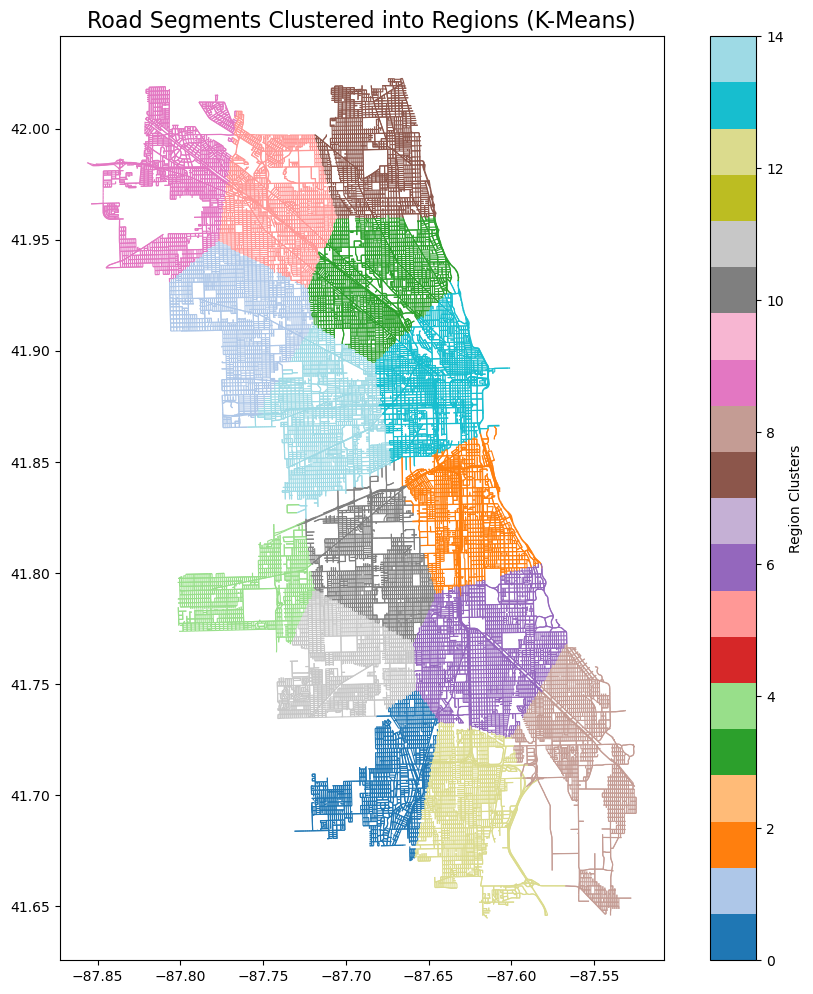

In [99]:
# Plot road segments, colored by their cluster (region)
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, graph=G, ax=ax, color='black', linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)

edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, legend_kwds={'label': "Region Clusters"})

# Add title
plt.title('Road Segments Clustered into Regions (K-Means)', fontsize=16)

shortest_routes_segs_df_group.apply(lambda row: plot_shortest_routes(row), axis=1)


### Check the traffic data from website

In [32]:
chicago_trafficdata=pd.read_csv('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments_20241112.csv')

In [ ]:
len(chicago_trafficdata)

In [ ]:
chicago_trafficdata.head()

In [ ]:
chicago_trafficdata.info()

In [ ]:
#convert the end points of each pair into nodes of the graph:
chicago_trafficdata['start_node']=chicago_trafficdata.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            row['START_LONGITUDE'],
                                                            row[' START_LATITUDE']),
                                                            axis=1)
chicago_trafficdata['end_node']=chicago_trafficdata.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            row['END_LONGITUDE'],
                                                            row[' END_LATITUDE']),
                                                            axis=1)

In [ ]:
chicago_trafficdata.to_csv('chicago_trafficdata_withnodes')

In [100]:
chicago_trafficdata=pd.read_csv('chicago_trafficdata_withnodes')

In [101]:
# Calculate the distance between the point and the nearest node
chicago_trafficdata['start_node_distance'] = chicago_trafficdata.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       row[' START_LATITUDE'],
                                                                       row['START_LONGITUDE'],
                                                                       G.nodes[row['start_node']]['y'], G.nodes[row['start_node']]['x']),
                                                                   axis=1)
chicago_trafficdata['end_node_distance'] = chicago_trafficdata.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       row[' END_LATITUDE'],
                                                                       row['END_LONGITUDE'],
                                                                       G.nodes[row['end_node']]['y'], G.nodes[row['end_node']]['x']),
                                                                   axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\1273812882.py:3: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.distance.great_circle_vec(
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\1273812882.py:9: FutureWarning: The `great_circle_vec` function has been renamed `great_circle`. Calling `great_circle_vec` will raise an error starting in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.distance.great_circle_vec(


In [ ]:
chicago_trafficdata['start_node_distance'].describe()

In [ ]:
chicago_trafficdata['end_node_distance'].describe()

In [ ]:
len(chicago_trafficdata[(chicago_trafficdata['start_node_distance']<150) &
                  (chicago_trafficdata['end_node_distance']<150)])/len(chicago_trafficdata)

In [102]:
chicago_trafficdata_nodes=chicago_trafficdata[(chicago_trafficdata['start_node_distance']<150) &
                  (chicago_trafficdata['end_node_distance']<150)]

In [36]:
len(chicago_trafficdata_nodes)

1114

In [ ]:
chicago_trafficdata_nodes.columns

In [103]:
chicago_trafficdata_nodes[' LAST_UPDATED']=pd.to_datetime(chicago_trafficdata_nodes[' LAST_UPDATED'])
chicago_trafficdata_nodes[' LAST_UPDATED'].info()

<class 'pandas.core.series.Series'>
Index: 1114 entries, 0 to 1256
Series name:  LAST_UPDATED
Non-Null Count  Dtype         
--------------  -----         
1114 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.4 KB


C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\2003770439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes[' LAST_UPDATED']=pd.to_datetime(chicago_trafficdata_nodes[' LAST_UPDATED'])


In [ ]:
len(chicago_trafficdata_nodes[chicago_trafficdata_nodes[' CURRENT_SPEED']==-1])

In [104]:
chicago_trafficdata_nodes['year']=chicago_trafficdata_nodes[' LAST_UPDATED'].apply(lambda x: x.year)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\124908571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes['year']=chicago_trafficdata_nodes[' LAST_UPDATED'].apply(lambda x: x.year)


In [ ]:
chicago_trafficdata_nodes[chicago_trafficdata_nodes[' CURRENT_SPEED']==-1]['year'].value_counts()

In [105]:
# further filter out data with unvalid current_speed and with the last update_time older than this year
mask=(chicago_trafficdata_nodes[' CURRENT_SPEED']==-1) & (chicago_trafficdata_nodes['year']<2024)
chicago_trafficdata_nodes_speed=chicago_trafficdata_nodes[~mask]
len(chicago_trafficdata_nodes_speed)

996

check whether the road segments obtained from the website traffic data have overlap with that in existing chicago dataset.

In [106]:
# calculate the shortest route by length
def get_shortest_route(row):
    try:
        shortest_route=nx.shortest_path(G, row['start_node'], row['end_node'], weight='length')
        shortest_route_length=nx.shortest_path_length(G, row['start_node'], row['end_node'], weight='length')
    except nx.NetworkXNoPath:
        shortest_route=np.nan
        shortest_route_length=np.nan
    return shortest_route, shortest_route_length

In [107]:
# Calculate the shortest route along with its length
chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \
                                                                                             chicago_trafficdata_nodes_speed.apply(
                                                                                                                                 lambda row:
                                                                                                                                pd.Series(get_shortest_route(row)), axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3509817815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3509817815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed[['shortest_route','shortest_route_length']]= \


In [108]:
# add a new column about the absolute difference between the actual trip_miles and 
#the calculated shortest route length
chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']=abs(chicago_trafficdata_nodes_speed['LENGTH']
                                                                  *1609.344-chicago_trafficdata_nodes_speed['shortest_route_length'])

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\3540466914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']=abs(chicago_trafficdata_nodes_speed['LENGTH']


In [ ]:
chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters'].describe()

In [109]:
chicago_trafficdata_nodes_speed_routes=chicago_trafficdata_nodes_speed[
    chicago_trafficdata_nodes_speed['absdiff_trip_shortest_meters']<500]

In [ ]:
chicago_trafficdata_nodes_speed_routes['shortest_route'].values[0]

In [ ]:
data_merged_routes_diff500_chopped['shortest_route'].values[0]

In [110]:
chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]]=chicago_trafficdata_nodes_speed_routes.apply(lambda row:
                                                                                                                          pd.Series(extract_road_segments_details(row)),
                                                                                                                          axis=1)

C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\4163048201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec',
C:\Users\cclin\AppData\Local\Temp\ipykernel_10708\4163048201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec',


In [ ]:
chicago_trafficdata_nodes_speed_routes[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]].head()

In [ ]:
chicago_trafficdata_nodes_speed_routes[
                                                               'edge_data_ls' 
                                                              ].values[0]

In [ ]:
len(chicago_trafficdata_nodes_speed_routes)

In [111]:
# combine all segments into a list
chicago_trafficdata_shortest_segs_ls=[]
for x in chicago_trafficdata_nodes_speed_routes['edge_data_ls'].values:
    chicago_trafficdata_shortest_segs_ls.extend(x)
len(chicago_trafficdata_shortest_segs_ls)

6882

In [ ]:
len(shortest_routes_segs_df_group)

In [112]:
chicago_trafficdata_shortest_segs_df=pd.DataFrame(chicago_trafficdata_shortest_segs_ls)
# remove list object 
chicago_trafficdata_shortest_segs_df=chicago_trafficdata_shortest_segs_df.apply(remove_list_obj)
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df.drop_duplicates()
len(chicago_trafficdata_shortest_segs_df_group)

6848

In [ ]:
chicago_trafficdata_shortest_segs_df_group.head()

In [ ]:
# Plot road segments in both datasets
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, color, ax=ax, linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)
shortest_routes_segs_df_group.apply(plot_shortest_routes, color='black', axis=1)
chicago_trafficdata_shortest_segs_df_group.apply(plot_shortest_routes, color='red',
                                                 axis=1)

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group.columns)

In [ ]:
chicago_trafficdata_shortest_segs_df_group.columns

In [ ]:
len(shortest_routes_segs_df_group.columns)

In [ ]:
shortest_routes_segs_df_group.columns

In [113]:
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df_group.reindex(shortest_routes_segs_df_group.columns, axis=1)

In [ ]:
chicago_trafficdata_shortest_segs_df_group['area'].isnull().sum()

In [ ]:
len(shortest_routes_segs_df_group)

In [ ]:
shortest_routes_segs_df_group['area'].isnull().sum()

In [114]:
segs_merge=pd.concat([shortest_routes_segs_df_group, chicago_trafficdata_shortest_segs_df_group],
                     ignore_index=False)

In [49]:
len(segs_merge)==len(shortest_routes_segs_df_group)+len(chicago_trafficdata_shortest_segs_df_group)

True

In [115]:
# redundent segments that already existed
segs_merge.duplicated().sum()/len(chicago_trafficdata_shortest_segs_df_group)

0.9028913551401869

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group)

In [ ]:
len(chicago_trafficdata_shortest_segs_df_group)-segs_merge.duplicated().sum()

In [116]:
# Identify common rows using isin and all columns
mask = chicago_trafficdata_shortest_segs_df_group.isin(
    shortest_routes_segs_df_group.to_dict(orient='list')
).all(axis=1)

# Keep rows not in common
filtered_chicago_trafficdata_shortest_segs_df_group = chicago_trafficdata_shortest_segs_df_group[~mask]
len(filtered_chicago_trafficdata_shortest_segs_df_group)


665

In [ ]:
# Plot road segments, colored by their cluster (region)
fig, ax = plt.subplots(figsize=(12, 12))
def plot_shortest_routes(row, color, ax=ax, linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)


shortest_routes_segs_df_group.apply(plot_shortest_routes, color='black', axis=1)
filtered_chicago_trafficdata_shortest_segs_df_group.apply(plot_shortest_routes, color='red',
                                                 axis=1)

### Check the road segment types

In [ ]:
edges.head()

In [ ]:
edges.columns

- The 'reversed' column in the edges GeoDataFrame typically indicates whether the direction of a road segment (edge) has been reversed relative to its default representation in the road network.
- 'bridge' represents whether a segment is a bridge. True or yes means it is a bridge, otherwise, being false or NaN means it is not a bridge.
- 'ref' contains reference identifiers for the segment.
- 'tunnel' represents whether a road segment is a tunnel. NaN means the edge is not a tunnel.
- 'access' describes access restrictions. If yes or NaN means no restrictions.
- 'junction' means whether a road is a part of a junction/intersection. NaN means the edge is not part of a junction.

To group edges based on their similarity for learning traffic patterns and performing route optimization, we should choose columns that are the most relevant attributes affecting traffic:
- region: Represents spatial clustering. Useful for capturing regional traffic behavior differences.
- highway: Traffic behavior differs significantly by road type.
- lanes: The number of lanes directly affects traffic capacity and congestion levels.
- speed_kph: Speed limits are crucial for understanding expected travel times and traffic flow.
- access: Indicates access restrictions, which could affect traffic density (e.g., private, permissive).
- junction: Important for identifying special road segments like roundabouts or complex intersections where traffic behavior differs.
- bridge and tunnel: These attributes often indicate constrained segments where traffic might behave differently due to structural limitations.

In [ ]:
edges['highway'].value_counts().index

- secondary:  medium sized roads that connect smaller towns or districts. less traffic than primary but more than tertiary.
- tertiary: smaller roads that connect villages or neighborhoods. moderate traffic.
- primary: major roads connect larger towns or cities. significant traffic flow but less than motorway and trunks.
- motorway_link: short connecting roads between motorways and other types of roads. Often used to enter or leave a motorway.
- motorway: high speed roads with limited access. Designed for long-distance and high-volume traffic.
- trunk: major roads, connecting cities or regions, but not motorway. Important for long-distance travel.
- emergency_bay: dedicated areas on motorway for emergency.
- living_street: roads primarily for pedestrain traffic, with restricted vehical access and with very low speed limit.
- ['residential', 'tertiary']: Could indicate a road that transitions between residential and tertiary classifications.

In [117]:
# remove list object for the following operation
chicago_trafficdata_shortest_segs_df_group=chicago_trafficdata_shortest_segs_df_group.apply(remove_list_obj)
segs_merge_uni=segs_merge.drop_duplicates()
segs_merge_uni=segs_merge_uni.apply(remove_list_obj)

In [118]:
grouping_columns = ['region', 'highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel']
edge_groups = edges.groupby(grouping_columns)
shortest_routes_edge_groups=shortest_routes_segs_df_group.groupby(grouping_columns)
chicago_trafficdata_shortest_edge_groups=chicago_trafficdata_shortest_segs_df_group.groupby(grouping_columns)
shortest_merge_edge_groups=segs_merge_uni.groupby(grouping_columns)

In [119]:
len(list(edge_groups))

1318

In [120]:
len(list(shortest_routes_edge_groups))

1082

In [121]:
len(list(chicago_trafficdata_shortest_edge_groups))

460

In [122]:
len(list(shortest_merge_edge_groups))

1109

In [123]:
1082/1318

0.8209408194233687

In [58]:
1406/1698

0.8280329799764429

In [ ]:
1437/1703

In [ ]:
edges['region'].value_counts().plot(kind='bar')

In [129]:
num_regions=15
num_seg_types={}
for i in range(num_regions):
    num_seg_types[f'region {i}']=len(list(edges[edges['region']==i].groupby(['highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [130]:
shortest_routes_num_seg_types={}
for i in range(num_regions):
    shortest_routes_num_seg_types[f'region {i}']=len(list(shortest_routes_segs_df_group[shortest_routes_segs_df_group['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [131]:
chicago_trafficdata_shortest_num_seg_types={}
for i in range(num_regions):
    chicago_trafficdata_shortest_num_seg_types[f'region {i}']=len(list(chicago_trafficdata_shortest_segs_df_group
                                                                       [chicago_trafficdata_shortest_segs_df_group['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [132]:
shortest_merge_num_seg_types={}
for i in range(num_regions):
    shortest_merge_num_seg_types[f'region {i}']=len(list(segs_merge_uni[segs_merge_uni['region']==i].
                                                                                                                                   groupby(['highway','lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])))

In [133]:
edge_types_comp=pd.DataFrame({'all_edge_types': num_seg_types, 
                              'shortest_routes_edge_types': shortest_routes_num_seg_types,
                              'chicago_trafficdata_shortest_edge_types': chicago_trafficdata_shortest_num_seg_types,
                             'shortest_merge_edge_types': shortest_merge_num_seg_types})
edge_types_comp['ratio']=edge_types_comp['shortest_routes_edge_types']/edge_types_comp['all_edge_types']
edge_types_comp['ratio_merge']=edge_types_comp['shortest_merge_edge_types']/edge_types_comp['all_edge_types']
edge_types_comp

,all_edge_types,shortest_routes_edge_types,chicago_trafficdata_shortest_edge_types,shortest_merge_edge_types,ratio,ratio_merge
region 0,34,22,11,22,0.647059,0.647059
region 1,70,54,24,57,0.771429,0.814286
region 2,115,97,29,98,0.843478,0.852174
region 3,107,102,38,102,0.953271,0.953271
region 4,58,33,26,39,0.568966,0.672414
region 5,95,87,29,87,0.915789,0.915789
region 6,108,99,26,99,0.916667,0.916667
region 7,87,75,33,76,0.862069,0.873563
region 8,72,52,20,52,0.722222,0.722222
region 9,89,61,28,68,0.685393,0.764045


In [64]:
edge_types_comp_29clusters=edge_types_comp

In [ ]:
edges[edges['region']==5].groupby(['highway', 'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [ ]:
shortest_routes_segs_df_group[shortest_routes_segs_df_group['region']==20].groupby(['highway', 
                                                                                   'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [ ]:
chicago_trafficdata_shortest_segs_df_group[chicago_trafficdata_shortest_segs_df_group['region']==5].groupby(['highway', 
                                                                                   'lanes', 'speed_kph', 'access', 'junction', 'bridge', 'tunnel'])['osmid'].count()

In [134]:
ls1=edge_types_comp['ratio'].to_list()
ls_r1=[round(x, 2) for x in ls1]
ls2=edge_types_comp['ratio_merge'].to_list()
ls_r2=[round(x, 2) for x in ls2]

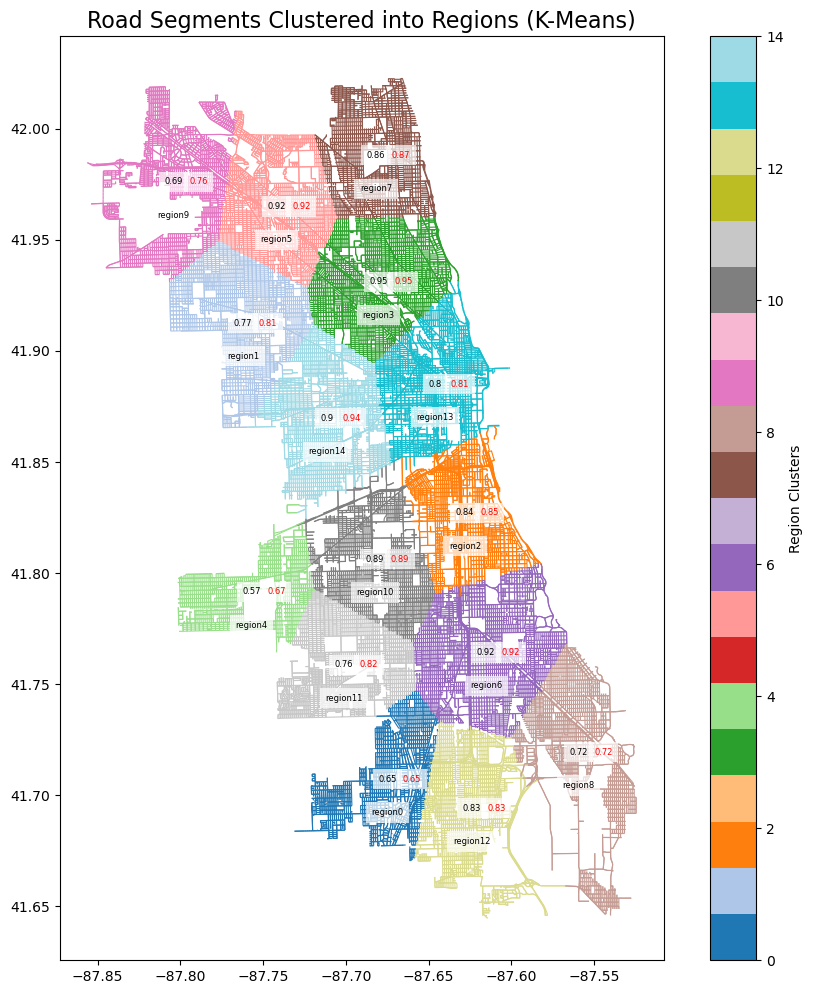

In [135]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot edges with clustering
edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, legend_kwds={'label': "Region Clusters"})

# Calculate and plot region labels
region_centroids = edges.groupby('region')['geometry'].apply(lambda x: x.unary_union.centroid)

for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y-0.015, f'region{region}',  # Adjust position slightly
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


# First set of numbers (from edge_types_comp['ratio'])
for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y, str(ls_r1[region]), 
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Second set of numbers (from edge_types_comp['ratio_merge'])

for region, centroid in region_centroids.items():
    ax.text(centroid.x + 0.015, centroid.y, str(ls_r2[region]),  # Adjust position slightly
            fontsize=6, ha='center', va='center', color='red', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add title
plt.title('Road Segments Clustered into Regions (K-Means)', fontsize=16)

plt.show()


### convert the existing trip level dataset into road segment level dataset

In [ ]:
data_merged_routes_diff500.columns

In [ ]:
len(data_merged_routes_diff500)

In [ ]:
# add the 'free_travel_time_total_sec' and 'edge_data_ls' columns to the original trip level dataset
data_merged_routes_diff500_chopped_subcols=data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 'shortest_route']]
trips_segs_merge=pd.merge(data_merged_routes_diff500, data_merged_routes_diff500_chopped_subcols, on='shortest_route')

In [ ]:
trips_segs_merge.head()

In [ ]:
len(trips_segs_merge)

#####  Distribute Trip Travel Time to Segments
Since trip-level data provides total travel time, we can estimate segment-level travel times by distributing the trip-level travel time across the matched road segments propotionally based on their free flow information. Specifically, based on the given speed limit and length, calculate the free-flow travel time ratio of each segment over the whole route, and then multiply this ratio to the actual total trip time to infer the actual travel time for each segment.

In [ ]:
X=pd.DataFrame(trips_segs_merge[ 'edge_data_ls'][0])
X.head()

In [ ]:
X.columns

In [ ]:
X['free_flow_time_ratio']=X['travel_time']/X['travel_time'].sum()

In [ ]:
X.head()

In [ ]:
X['inferred_travel_time_sec']=X['free_flow_time_ratio']*trips_segs_merge['trip_seconds'].values[0]

In [ ]:
X.head()

In [ ]:
X['inferred_travel_time_sec'].sum()

In [ ]:
trips_segs_merge['trip_seconds'].values[0]

In [ ]:
X[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]=trips_segs_merge[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']].values[0]

In [ ]:
X.columns

In [ ]:
X.head()

##### Note that the following cell cant be run in notebook since it will cause page snapped. You need to run another copy of py script in anaconda prompt.

In [ ]:
# the following code can be run in notebook since it will cause page snapped. Need to run it in Anaconda prompt
def create_seg_level_df (row):
    total_free_travel_time=row['free_travel_time_total_sec']
    X=pd.DataFrame(row['edge_data_ls'])[[ 'lanes',  'highway', 
        'speed_kph', 'travel_time', 'region',  'u', 'v', 'junction',
       'bridge', 'tunnel', 'access']]
    X['inferred_travel_time_sec']=X['travel_time']/total_free_travel_time*row['trip_seconds']
    X[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]=row[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]
    return X
chunk_size = 100  # Adjust based on available memory

# Open the file in append mode and write chunks incrementally
for i in range(0, len(trips_segs_merge), chunk_size):
    chunk = trips_segs_merge.iloc[i:i + chunk_size]
    chunk_result = pd.concat(chunk.apply(create_seg_level_df, axis=1).to_list(), ignore_index=True)
    
    # Write chunk results to file
    chunk_result.to_csv('segment_level_data.csv', mode='a', index=False, header=(i == 0));  

### EDA on segment level

In [160]:
!pip install statsmodels

In [136]:
!pip install dask

In [151]:
import dask.dataframe as dd
from statsmodels.tsa.seasonal import seasonal_decompose
import gc

In [2]:
# Load the CSV lazily with Dask
ddf = dd.read_csv('segment_level_data.csv')

print(ddf.dtypes)

lanes                               float64
highway                     string[pyarrow]
speed_kph                           float64
travel_time                         float64
region                                int64
u                                     int64
v                                     int64
junction                    string[pyarrow]
bridge                      string[pyarrow]
tunnel                      string[pyarrow]
access                      string[pyarrow]
inferred_travel_time_sec            float64
Unnamed: 0                            int64
trip_start_timestamp        string[pyarrow]
trip_end_timestamp          string[pyarrow]
temp                                float64
dwpt                                float64
rhum                                float64
prcp                                float64
wdir                                float64
wpgt                                float64
pres                                float64
dtype: object


In [3]:
for region in range(29):
    print(region)
    filtered_region = ddf[ddf['region'] == region]
    
    # Save the filtered data directly to a file
    filtered_region.to_csv(f'filtered_region_{region}.csv', single_file=True, index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [166]:
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['week_of_year'] = data_merged_routes_diff500['trip_start_timestamp'].dt.isocalendar().week
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour
total_yearly=data_merged_routes_diff500['year'].value_counts(normalize=True).sort_index()
yearly_comp=pd.DataFrame({'total_yearly': total_yearly})
total_monthly=data_merged_routes_diff500['month'].value_counts(normalize=True).sort_index()
monthly_comp=pd.DataFrame({'total_monthly': total_monthly})
total_daily=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 
                                                                                        'Friday', 'Saturday', 'Sunday'], axis=1)
daily_comp=pd.DataFrame({'total_daily': total_daily})
total_hourly=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
hourly_comp=pd.DataFrame({'total_hourly': total_hourly})

In [152]:
yearly_comp_p=yearly_comp
monthly_comp_p=monthly_comp
daily_comp_p=daily_comp
hourly_comp_p=hourly_comp

In [167]:
# Loop through each region
for region in range(29):
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['week_of_year'] = filtered_region['trip_start_timestamp'].dt.isocalendar().week
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    
    # temporal pattern comparison
    region_yearly=filtered_region['year'].value_counts(normalize=True).sort_index()
    yearly_comp[f'region_{region}_yearly']=region_yearly
    region_monthly=filtered_region['month'].value_counts(normalize=True).sort_index()
    monthly_comp[f'region_{region}_monthly']=region_monthly
    region_daily=filtered_region['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 
                                                                                  'Friday', 'Saturday', 'Sunday'], axis=1)
    daily_comp[f'region_{region}_daily']=region_daily
    region_hourly=filtered_region['hour_start'].value_counts(normalize=True).sort_index()
    hourly_comp[f'region_{region}_hourly']=region_hourly 
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

Processed and cleared region 0
Processed and cleared region 1
Processed and cleared region 2
Processed and cleared region 3
Processed and cleared region 4
Processed and cleared region 5
Processed and cleared region 6
Processed and cleared region 7
Processed and cleared region 8
Processed and cleared region 9
Processed and cleared region 10
Processed and cleared region 11
Processed and cleared region 12
Processed and cleared region 13
Processed and cleared region 14
Processed and cleared region 15
Processed and cleared region 16
Processed and cleared region 17
Processed and cleared region 18
Processed and cleared region 19
Processed and cleared region 20
Processed and cleared region 21
Processed and cleared region 22
Processed and cleared region 23
Processed and cleared region 24
Processed and cleared region 25
Processed and cleared region 26
Processed and cleared region 27
Processed and cleared region 28


In [168]:
monthly_comp

,total_monthly,region_0_monthly,region_1_monthly,region_2_monthly,region_3_monthly,region_4_monthly,region_5_monthly,region_6_monthly,region_7_monthly,region_8_monthly,...,region_19_monthly,region_20_monthly,region_21_monthly,region_22_monthly,region_23_monthly,region_24_monthly,region_25_monthly,region_26_monthly,region_27_monthly,region_28_monthly
month,,,,,,,,,,,,,,,,,,,,,
1,0.083293,0.085275,0.082476,0.078542,0.085328,0.074556,0.075875,0.089998,0.080441,0.085600,...,0.078002,0.079936,0.080420,0.080819,0.096209,0.082134,0.077416,0.080873,0.083028,0.062428
2,0.082718,0.090550,0.085187,0.078554,0.094047,0.078162,0.073489,0.084492,0.080184,0.091416,...,0.080808,0.076129,0.084381,0.094594,0.083781,0.078887,0.082972,0.078714,0.094213,0.095954
3,0.094069,0.100881,0.094998,0.093442,0.102808,0.089017,0.089924,0.093350,0.097113,0.095253,...,0.095286,0.089211,0.094466,0.100393,0.113609,0.091629,0.096340,0.089051,0.105461,0.092486
4,0.083988,0.085140,0.086349,0.082390,0.088385,0.086975,0.079071,0.090173,0.089844,0.088255,...,0.086346,0.086841,0.082519,0.091638,0.086047,0.086990,0.085234,0.085440,0.088370,0.147977
5,0.078568,0.082365,0.076758,0.078470,0.078579,0.085352,0.084061,0.077361,0.076059,0.078534,...,0.075226,0.079035,0.077556,0.077415,0.083964,0.078203,0.075355,0.082234,0.079742,0.129480
6,0.078643,0.076270,0.075248,0.082087,0.071432,0.086658,0.086618,0.077962,0.083261,0.072796,...,0.080322,0.080681,0.077455,0.070747,0.081295,0.080986,0.075174,0.079846,0.071591,0.076301
7,0.081800,0.074801,0.073591,0.087399,0.075329,0.087130,0.092887,0.075914,0.076326,0.075604,...,0.081902,0.085647,0.082393,0.076127,0.074204,0.084055,0.084276,0.079942,0.074071,0.060116
8,0.080486,0.077867,0.080547,0.084973,0.078683,0.081727,0.081566,0.079512,0.073125,0.080781,...,0.086893,0.086793,0.079228,0.077690,0.062763,0.084497,0.079431,0.080387,0.080067,0.068208
9,0.080949,0.076057,0.081471,0.083919,0.073381,0.084168,0.085090,0.078755,0.082308,0.085824,...,0.076697,0.083921,0.083984,0.081773,0.079833,0.082177,0.087747,0.083876,0.074255,0.049711


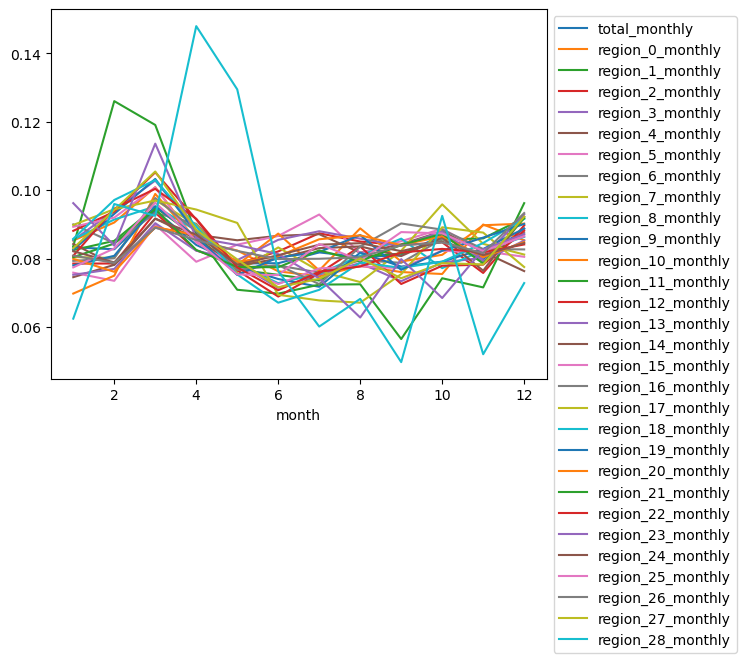

In [169]:
monthly_comp.plot(kind='line')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position legend outside the plot

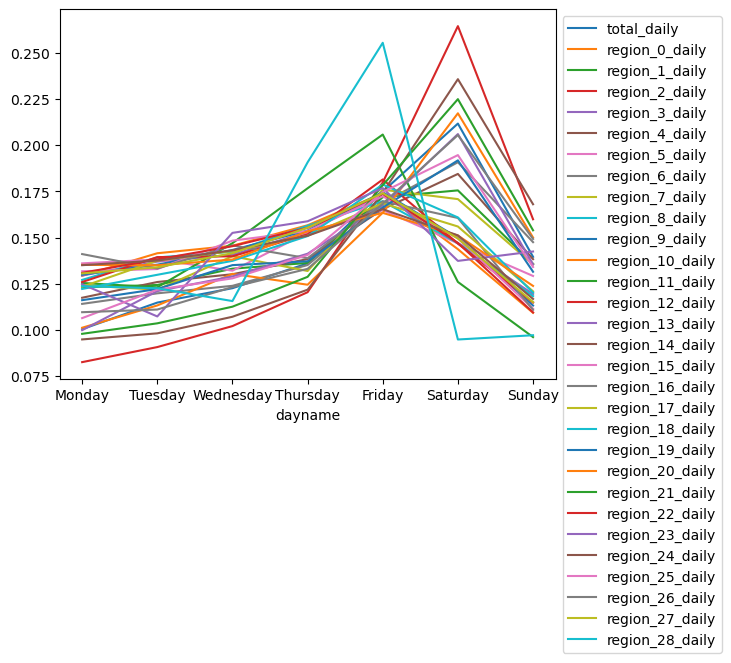

In [170]:
daily_comp.plot(kind='line')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

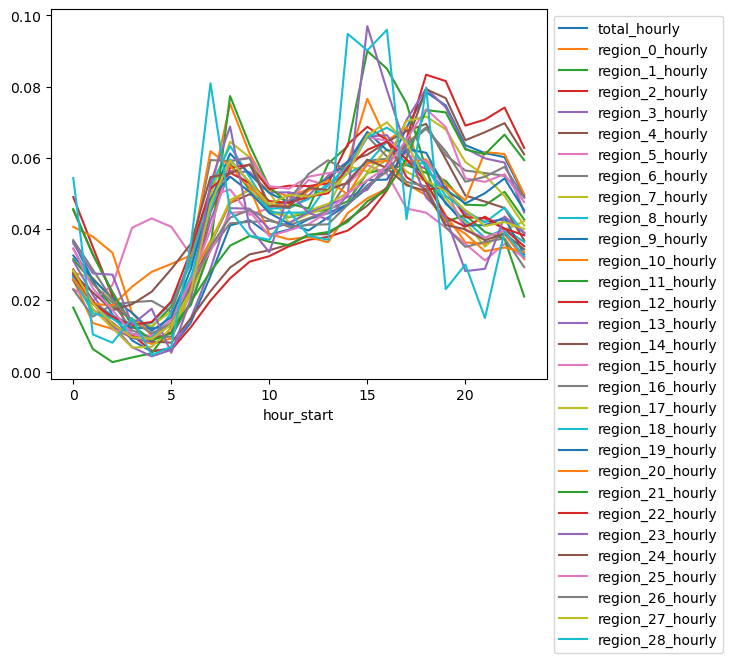

In [171]:
hourly_comp.plot(kind='line')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [167]:
filtered_region0.columns

Index(['lanes', 'highway', 'speed_kph', 'travel_time', 'region', 'u', 'v',
       'junction', 'bridge', 'tunnel', 'access', 'inferred_travel_time_sec',
       'Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 'temp',
       'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres', 'year', 'month',
       'dayname', 'hour_start', 'hour_end'],
      dtype='object')

In [171]:
 filtered_region0.groupby(
    ['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access']
)['inferred_travel_time_sec'].mean()

highway                      speed_kph  lanes  junction  bridge   tunnel  access
['tertiary', 'residential']  41.6       2.0    no        yes      no      yes       24.990853
motorway_link                74.2       1.0    no        no       no      yes       25.768769
primary                      48.3       2.0    no        no       no      yes       10.982701
                                        2.5    no        no       no      yes       18.771946
                                        3.0    no        no       no      yes       13.970990
                                        3.5    no        no       no      yes       10.917922
                                                         viaduct  no      yes        9.992439
                             49.2       2.0    no        no       no      yes        8.518011
                                        2.5    no        no       no      yes        9.877903
                                        3.0    no        no       no     

In [168]:
# cluster similar segments into groups  and assign unique labels to each group
filtered_region0['segment_type'] = filtered_region0.groupby(
    ['highway', 'speed_kph', 'lanes', 'junction', 'bridge', 'tunnel', 'access']
).ngroup()

In [170]:
filtered_region0['segment_type'].value_counts(normalize=True).sort_index()

segment_type
0     0.000882
1     0.000053
2     0.003394
3     0.006198
4     0.004671
5     0.002212
6     0.002586
7     0.039042
8     0.017814
9     0.009009
10    0.003321
11    0.000033
12    0.416526
13    0.000644
14    0.004946
15    0.047050
16    0.013200
17    0.263826
18    0.001116
19    0.000542
20    0.004798
21    0.027582
22    0.016315
23    0.000279
24    0.000094
25    0.015351
26    0.001121
27    0.096928
28    0.000464
Name: proportion, dtype: float64